# Optimize a dense network with Bayesian optimization
Authors: Javier Duarte, Thong Nguyen

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VBF signal and one corresponding to the background.

In [1]:
import torch
import numpy as np
import pandas as pd
import uproot
import os
import gc

lumi_2022=7980
lumi_2022EE=26670

arg_no_horn=1

root_dir = "/eos/user/y/yulou/HiggsDNA/samples/5-6_right/2022sample"
file_keyword = "NOTAG" 
suffix_2022 = "2022"
suffix_2022EE = "2022EE"

paths_2022 = []
paths_2022EE = []

for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".parquet") and file_keyword in file:
            parent_folder = os.path.basename(root)
            if parent_folder.endswith(suffix_2022):
                paths_2022.append(os.path.join(root, file))
            elif parent_folder.endswith(suffix_2022EE):
                paths_2022EE.append(os.path.join(root, file))

df_2022 = pd.concat(
    [pd.read_parquet(path, engine='pyarrow').assign(file_path=path) for path in paths_2022],
    ignore_index=True
)

df_2022['lumi'] = lumi_2022

df_2022MC=df_2022

del df_2022
gc.collect()


20

In [2]:
#print(df_2022MC['file_path'].unique())

In [3]:
conditions = [
    df_2022MC['file_path'].str.contains('VBF'), 
    df_2022MC['file_path'].str.contains('DY'),
    df_2022MC['file_path'].str.contains('EWK'),
    df_2022MC['file_path'].str.contains('TTto2L2Nu')
]
choices = ['VBF', 'DY','EWK','tt']
df_2022MC['category'] = np.select(conditions, choices, default='others') 

df_2022MC['WET']=df_2022MC['weight']*df_2022MC['lumi']*df_2022MC['cross_section']

In [4]:

df_2022data=pd.concat(
    [pd.read_parquet(path, engine='pyarrow').assign(file_path=path) for path in [
        "/eos/user/y/yulou/HiggsDNA/samples/5-6_right/2022sample/Data/DataC_2022_NOTAG_merged.parquet",
        "/eos/user/y/yulou/HiggsDNA/samples/5-6_right/2022sample/Data/DataD_2022_NOTAG_merged.parquet",        
    ]],
    ignore_index=True
)

df_2022data['category']='data'
df_2022data['WET']=1

In [5]:
df_2022=pd.concat([df_2022MC, df_2022data], axis=0)

del df_2022MC,df_2022data
gc.collect()

18

In [6]:
print("VBF count",df_2022[(df_2022['category']=='VBF')]['WET'].sum())
print("DY count",df_2022[(df_2022['category']=='DY')]['WET'].sum())
print("EWK count",df_2022[(df_2022['category']=='EWK')]['WET'].sum())
print("tt count",df_2022[(df_2022['category']=='tt')]['WET'].sum())
print("others count",df_2022[(df_2022['category']=='others')]['WET'].sum())

VBF count 2.5680256691677807
DY count 427350.47072096803
EWK count 2007.5736163201295
tt count 21337.455203692843
others count 3074.8959181689306


In [7]:
VARS = [    
             'dimuon_mass', 'dimuon_pt', 'dimuon_eta', 'dimuon_phi',
                  
            'dijet_pt', 'dijet_eta', 'dijet_phi', 'dijet_mass', 
    
            'jet_leading_pt', 'jet_leading_eta', 'jet_leading_phi','jet_leading_mass',
            'jet_subleading_pt', 'jet_subleading_eta', 'jet_subleading_phi','jet_subleading_mass',
            #'jet_lead_btagDeepFlav_QG','jet_sublead_btagDeepFlav_QG',
        
            "lljj_mass",   
            "lljj_pt"  ,   
            "lljj_eta" ,
            "lljj_phi" ,
            
            'muon_lead_pt', 'muon_lead_eta', 'muon_lead_phi', 'muon_lead_charge', 
            'muon_sublead_pt', 'muon_sublead_eta', 'muon_sublead_phi', 'muon_sublead_charge',
            #'muon_sublead_mass',   'muon_lead_mass',
            
            'dEta_2lep',
            'dPhi_2lep',
            'dRmm_2lep',
            
            "dEta_jj"  ,# already abs value
            #"dEta_jj_abs",
            "dPhi_jj"  ,
            #??"dPhi_jj_mod"    : (op.deltaPhi(jets[0].p4, jets[1].p4) + np.pi) % (2 * np.pi) - np.pi,
            #??"dPhi_jj_mod_abs": op.abs((op.deltaPhi(jets[0].p4, jets[1].p4) + np.pi) % (2 * np.pi) - np.pi),
            
            "dRmin_mj","dRmax_mj",'dRmin_mmj','dRmax_mmj',
        
            'dimuon_rapidity',#Higgs rapidity
            'minEtaHQ','minPhiHQ',#mm_eta-jet_eta'
            #'Rpt',the value is 1
            'cthetaCS',#!!! need to be checked
            'log(ll_zstar)'
        
        #other vars in run2
        
        
       ]


df_2022['dEta_2lep'] = abs(df_2022['muon_lead_eta']-df_2022['muon_sublead_eta'])
df_2022['dPhi_2lep'] = abs(df_2022['muon_lead_phi']-df_2022['muon_sublead_phi'])
df_2022['dPhi_2lep'] = np.where(df_2022['dPhi_2lep'] > np.pi, 2*np.pi - df_2022['dPhi_2lep'], df_2022['dPhi_2lep'])
df_2022['dRmm_2lep'] = np.sqrt(df_2022['dEta_2lep']**2 + df_2022['dPhi_2lep']**2)

df_2022['dEta_jj'] = abs(df_2022['jet_leading_eta']-df_2022['jet_subleading_eta'])
df_2022['dPhi_jj'] = abs(df_2022['jet_leading_phi']-df_2022['jet_subleading_phi'])
df_2022['dPhi_jj'] = np.where(df_2022['dPhi_jj'] > np.pi, 2*np.pi - df_2022['dPhi_jj'], df_2022['dPhi_jj'])


dimuon_px = df_2022['dimuon_pt'] * np.cos(df_2022['dimuon_phi'])
dimuon_py = df_2022['dimuon_pt'] * np.sin(df_2022['dimuon_phi'])
dimuon_pz = df_2022['dimuon_pt'] * np.sinh(df_2022['dimuon_eta'])
dimuon_E = np.sqrt(dimuon_px**2 + dimuon_py**2 + dimuon_pz**2 + df_2022['dimuon_mass']**2)

dijet_px = df_2022['dijet_pt'] * np.cos(df_2022['dijet_phi'])
dijet_py = df_2022['dijet_pt'] * np.sin(df_2022['dijet_phi'])
dijet_pz = df_2022['dijet_pt'] * np.sinh(df_2022['dijet_eta'])
dijet_E = np.sqrt(dijet_px**2 + dijet_py**2 + dijet_pz**2 + df_2022['dijet_mass']**2)

total_px = dimuon_px + dijet_px
total_py = dimuon_py + dijet_py
total_pz = dimuon_pz + dijet_pz
total_E = dimuon_E + dijet_E

df_2022['lljj_pt'] = np.sqrt(total_px**2 + total_py**2)
df_2022['lljj_phi'] = np.arctan2(total_py, total_px)
df_2022['lljj_eta'] = np.arcsinh(total_pz / df_2022['lljj_pt'])
df_2022['lljj_mass'] = np.sqrt(total_E**2 - (total_px**2 + total_py**2 + total_pz**2))

df_2022['dimuon_rapidity'] = 0.5 * np.log(
    (dimuon_E + dimuon_pz) / 
    (dimuon_E - dimuon_pz)
)

def calculate_rapidity(var):

    pt = df_2022[f'{var}_pt']
    eta = df_2022[f'{var}_eta']
    phi = df_2022[f'{var}_phi']
    mass = df_2022[f'{var}_mass']

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
        
    rapidity = 0.5 * np.log( (E + pz) / (E - pz))
    return rapidity

df_2022['jet_leading_rapidity'] = calculate_rapidity("jet_leading")
df_2022['jet_subleading_rapidity'] = calculate_rapidity("jet_subleading")

df_2022['log(ll_zstar)'] = np.log(abs((df_2022['dimuon_rapidity'] - 0.5*(df_2022['jet_leading_rapidity'] + df_2022['jet_subleading_rapidity']))/(df_2022['jet_leading_rapidity']-df_2022['jet_subleading_rapidity'])))


def deltaR(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = np.abs(phi1 - phi2) % (2 * np.pi) 
    dphi = np.where(dphi > np.pi, 2 * np.pi - dphi, dphi) 
    return np.sqrt(deta**2 + dphi**2)

df_2022['dR_mu1_j1'] = deltaR(df_2022['muon_lead_eta'], df_2022['muon_lead_phi'], 
                             df_2022['jet_leading_eta'], df_2022['jet_leading_phi'])
df_2022['dR_mu1_j2'] = deltaR(df_2022['muon_lead_eta'], df_2022['muon_lead_phi'], 
                             df_2022['jet_subleading_eta'], df_2022['jet_subleading_phi'])
df_2022['dR_mu2_j1'] = deltaR(df_2022['muon_sublead_eta'], df_2022['muon_sublead_phi'], 
                             df_2022['jet_leading_eta'], df_2022['jet_leading_phi'])
df_2022['dR_mu2_j2'] = deltaR(df_2022['muon_sublead_eta'], df_2022['muon_sublead_phi'], 
                             df_2022['jet_subleading_eta'], df_2022['jet_subleading_phi'])


df_2022['dRmin_mj'] = df_2022[['dR_mu1_j1', 'dR_mu1_j2', 'dR_mu2_j1', 'dR_mu2_j2']].min(axis=1)
df_2022['dRmax_mj'] = df_2022[['dR_mu1_j1', 'dR_mu1_j2', 'dR_mu2_j1', 'dR_mu2_j2']].max(axis=1)

df_2022 = df_2022.drop(columns=['dR_mu1_j1', 'dR_mu1_j2', 'dR_mu2_j1', 'dR_mu2_j2'])

dR_pairs_mmj = [
    deltaR(df_2022['dimuon_eta'], df_2022['dimuon_phi'], 
           df_2022['jet_leading_eta'], df_2022['jet_leading_phi']),
    deltaR(df_2022['dimuon_eta'], df_2022['dimuon_phi'], 
           df_2022['jet_subleading_eta'], df_2022['jet_subleading_phi'])
]
df_2022['dRmin_mmj'] = np.min(dR_pairs_mmj, axis=0)
df_2022['dRmax_mmj'] = np.max(dR_pairs_mmj, axis=0)


df_2022['minEtaHQ_j1'] = abs(df_2022['dimuon_eta'] - df_2022['jet_leading_eta'])
df_2022['minEtaHQ_j2'] = abs(df_2022['dimuon_eta'] - df_2022['jet_subleading_eta'])
df_2022['minEtaHQ'] = df_2022[['minEtaHQ_j1', 'minEtaHQ_j2']].min(axis=1)

df_2022['minPhiHQ_j1'] = abs(df_2022['dimuon_phi'] - df_2022['jet_leading_phi'])
df_2022['minPhiHQ_j2'] = abs(df_2022['dimuon_phi'] - df_2022['jet_subleading_phi'])
df_2022['minPhiHQ'] = df_2022[['minPhiHQ_j1', 'minPhiHQ_j2']].min(axis=1)


df_2022['Rpt'] = df_2022['lljj_pt'] / (df_2022['dimuon_pt'] + df_2022['jet_leading_pt'] + df_2022['jet_subleading_pt'])


df_2022['muon_lead_pz'] = df_2022['muon_lead_pt'] * np.sinh(df_2022['muon_lead_eta'])
df_2022['muon_lead_E'] = np.sqrt(
    (df_2022['muon_lead_pt'] * np.cosh(df_2022['muon_lead_eta']))**2 + df_2022['muon_lead_mass']**2
)

df_2022['muon_sublead_pz'] = df_2022['muon_sublead_pt'] * np.sinh(df_2022['muon_sublead_eta'])
df_2022['muon_sublead_E'] = np.sqrt(
    (df_2022['muon_sublead_pt'] * np.cosh(df_2022['muon_sublead_eta']))**2 + df_2022['muon_sublead_mass']**2
)


numerator = 2 * (df_2022['muon_lead_pz'] * df_2022['muon_sublead_E'] - 
                df_2022['muon_lead_E'] * df_2022['muon_sublead_pz'])
denominator = df_2022['dimuon_mass'] * np.sqrt(df_2022['dimuon_mass']**2 + df_2022['dimuon_pt']**2)
epsilon = 1e-8
df_2022['cthetaCS'] = numerator / (denominator + epsilon)




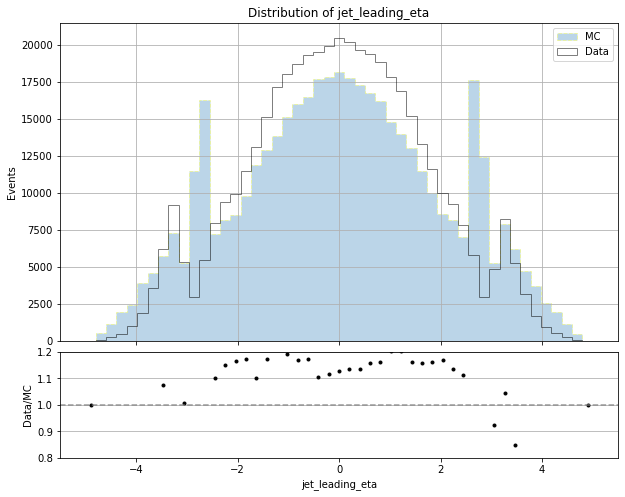

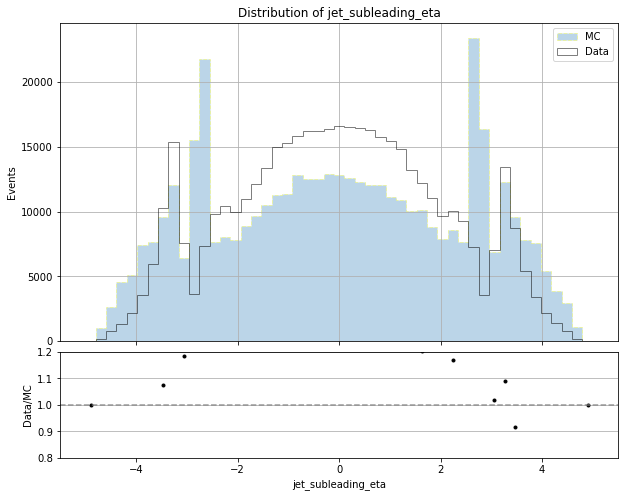

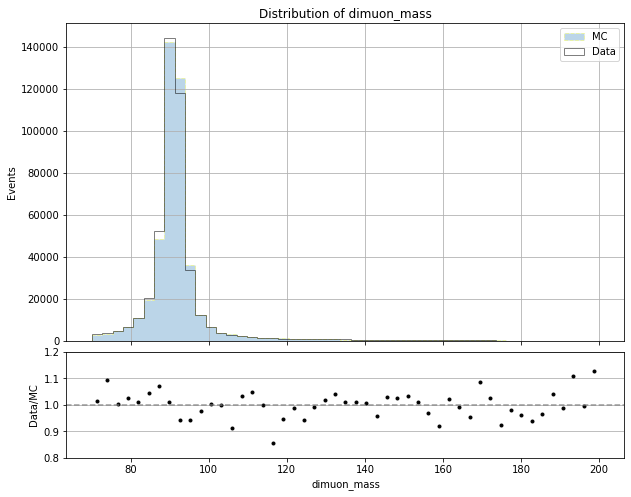

In [8]:
import matplotlib.pyplot as plt
import numpy as np

for var in ['jet_leading_eta','jet_subleading_eta','dimuon_mass']:

    fig, (ax_main, ax_ratio) = plt.subplots(
        2, 1, 
        figsize=(10, 8), 
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=True
    )
    

    if var in ['jet_leading_eta','jet_subleading_eta']:
        bins = np.linspace(-5,5,50)
    else:
        bins = np.linspace(df_2022[var].min(),df_2022[var].max(),50)
    

    scaled_weights = df_2022['WET']
    

    mc_mask = df_2022['category'] != 'data'
    data_mask = df_2022['category'] == 'data'
    
    mc_counts, _ = np.histogram(df_2022[mc_mask][var], bins=bins, weights=scaled_weights[mc_mask])
    data_counts, _ = np.histogram(df_2022[data_mask][var], bins=bins, weights=scaled_weights[data_mask])
    

    ax_main.hist(
        df_2022[mc_mask][var], 
        bins=bins, 
        alpha=0.3, 
        weights=scaled_weights[mc_mask], 
        histtype='stepfilled', 
        edgecolor='yellow', 
        linestyle='--',
        label='MC'
    )
    
    ax_main.hist(
        df_2022[data_mask][var], 
        bins=bins, 
        alpha=0.5, 
        weights=scaled_weights[data_mask], 
        histtype='step',
        edgecolor='black', 
        linestyle='-',
        label='Data'
    )
    

    ax_main.set_ylabel('Events')
    ax_main.set_title(f'Distribution of {var}')
    ax_main.legend()
    ax_main.grid(True)
    

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.divide(data_counts, mc_counts, out=np.ones_like(data_counts), where=mc_counts!=0)
    

    bin_centers = 0.5*(bins[1:] + bins[:-1])
    

    ax_ratio.plot(
        bin_centers,       
        ratio,             
        marker='o',        
        markersize=3,      
        color='black',     
        linestyle='None',  
        label='Data/MC'     
    )
    
    ax_ratio.axhline(1, color='gray', ls='--', alpha=0.8)
    ax_ratio.set_ylabel('Data/MC')
    ax_ratio.set_ylim(0.8, 1.2)
    ax_ratio.grid(True, axis='y')
    
    ax_ratio.set_xlabel(f'{var}')
    
    plt.subplots_adjust(hspace=0.05)
    plt.show()

In [9]:
df_2022=df_2022[(df_2022['dimuon_mass'] > 115) & (df_2022['dimuon_mass'] < 135)]
df_2022=df_2022[(df_2022['jet_leading_pt'] > 35) & (df_2022['jet_subleading_pt'] > 26)]
df_2022=df_2022[abs(df_2022['jet_leading_eta'] - df_2022['jet_subleading_eta'])>2.5]
df_2022=df_2022[(df_2022['dijet_mass']> 400)]

no_horn_region_sel = ~((abs(df_2022['jet_leading_eta']) > 2.6) & (abs(df_2022['jet_leading_eta']) < 2.9)) | ((abs(df_2022['jet_subleading_eta']) > 2.6) & (abs(df_2022['jet_subleading_eta']) < 2.9))
if arg_no_horn==1:
    df_2022=df_2022[no_horn_region_sel]

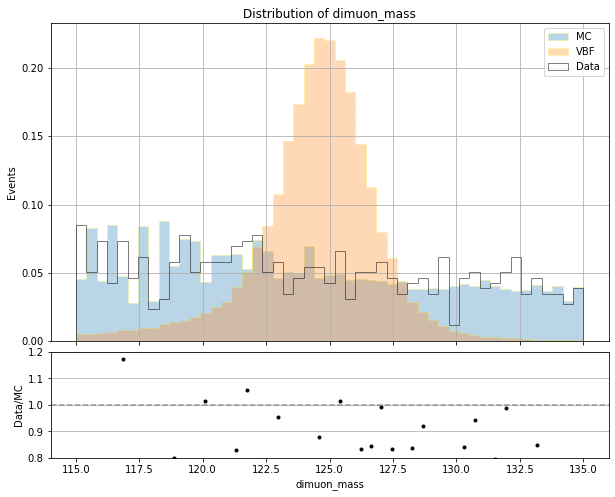

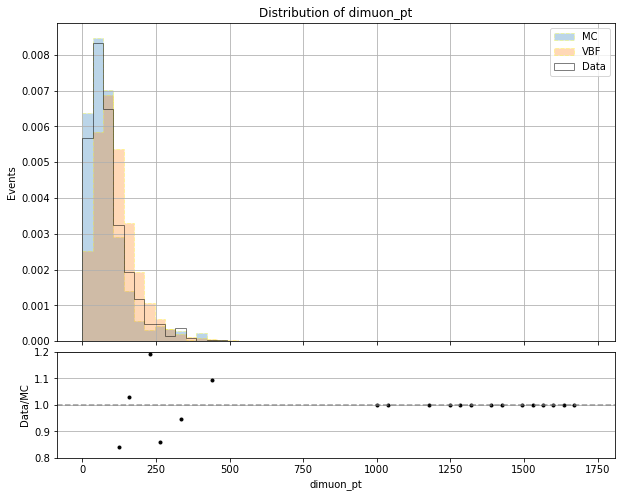

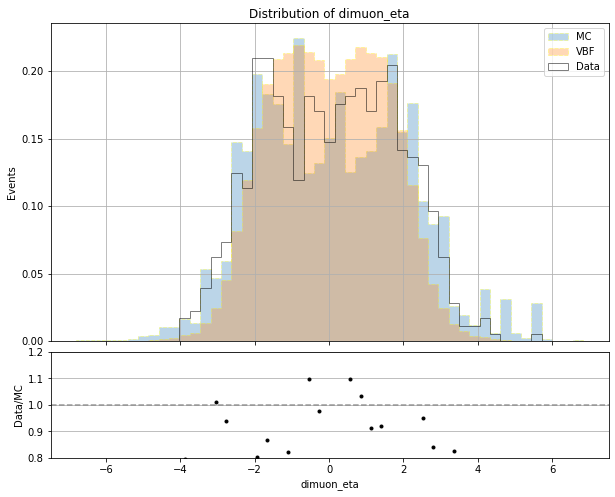

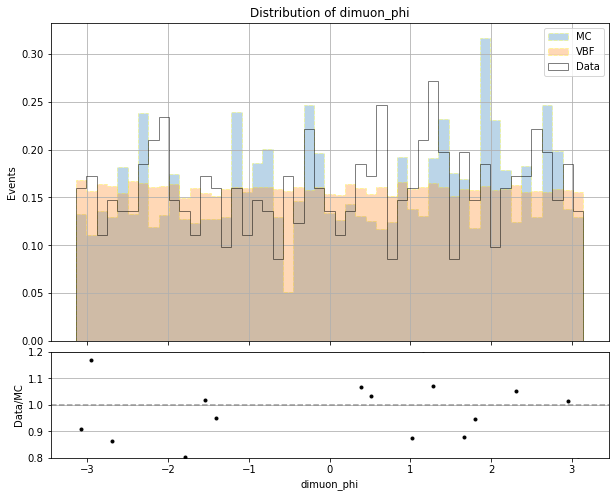

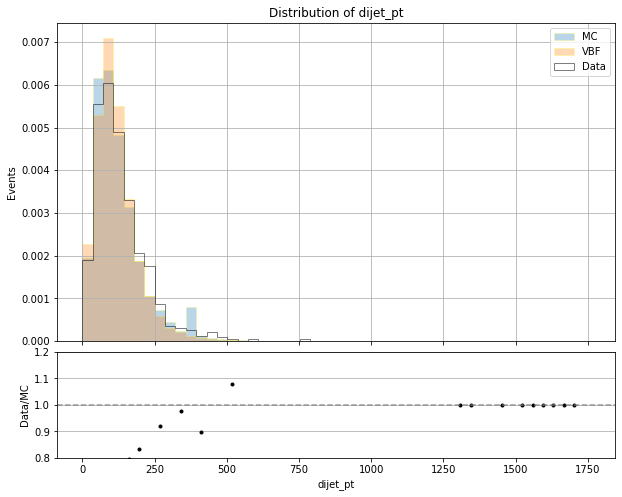

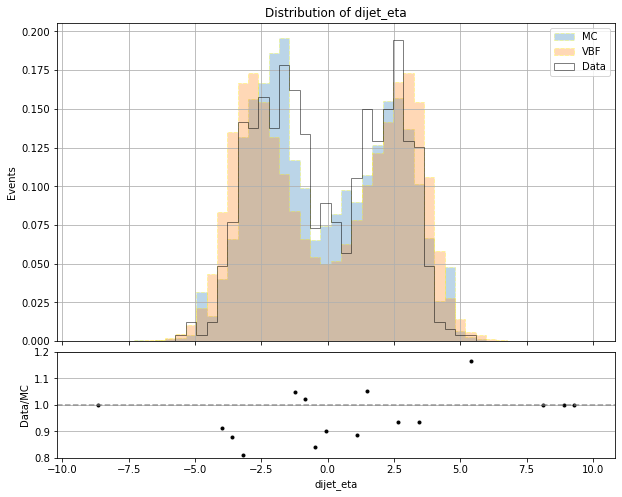

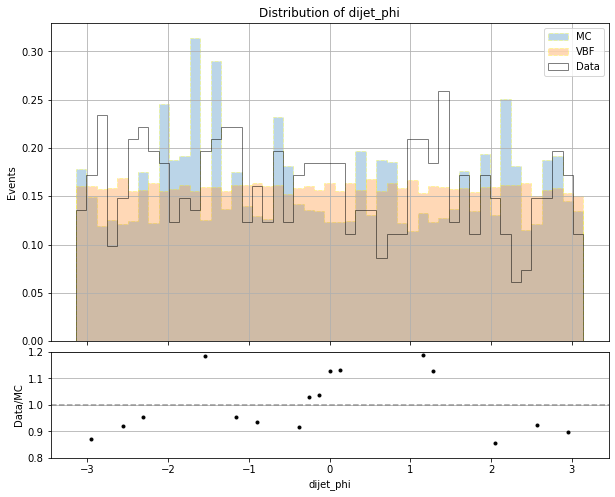

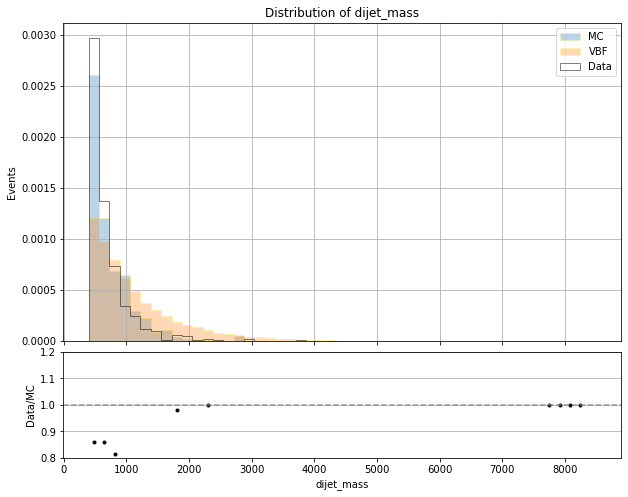

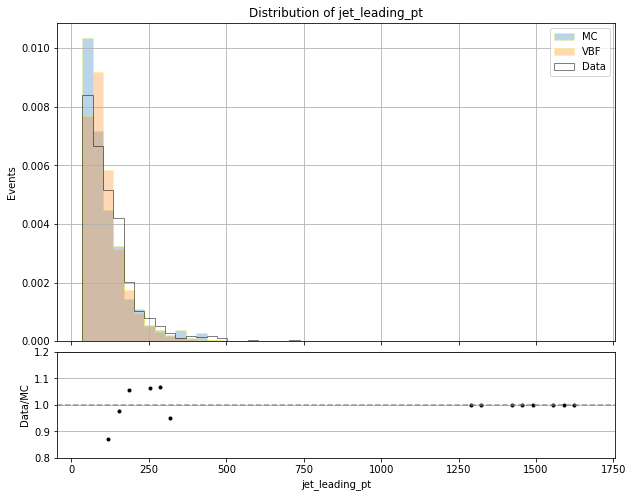

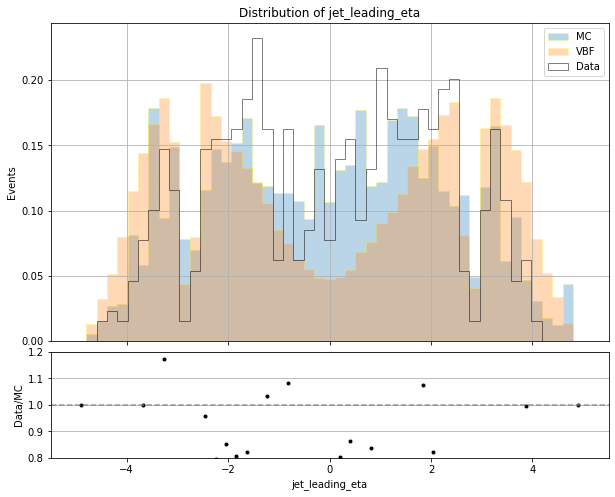

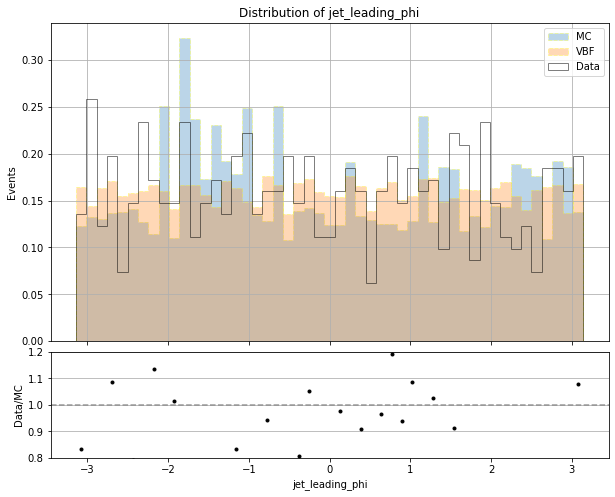

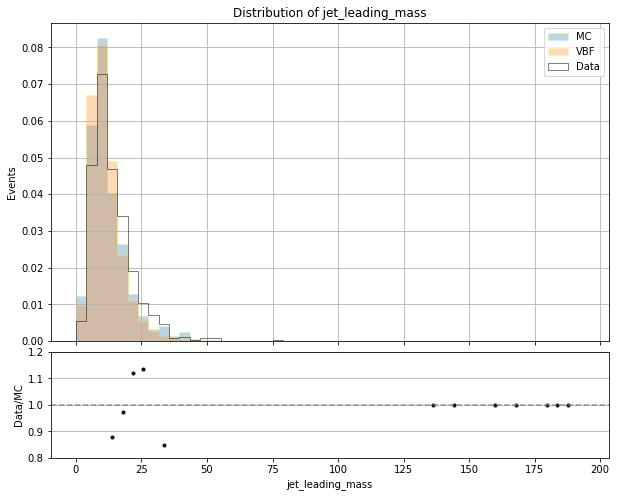

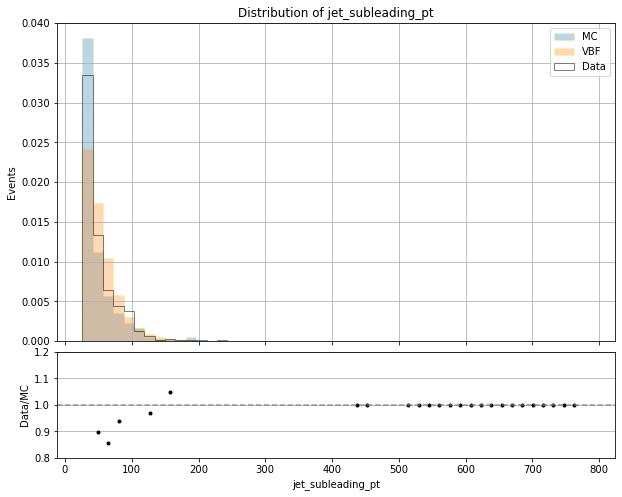

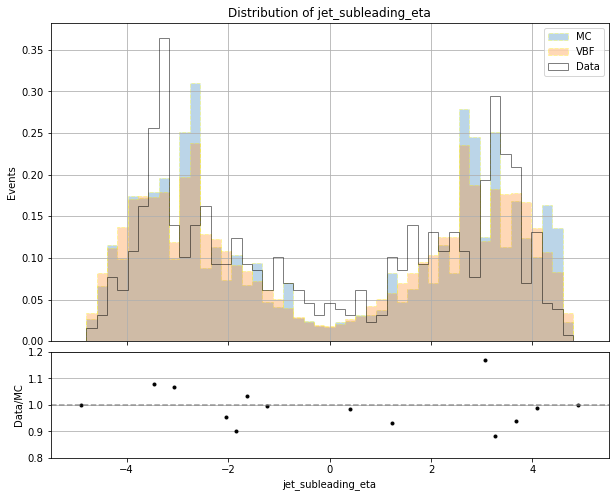

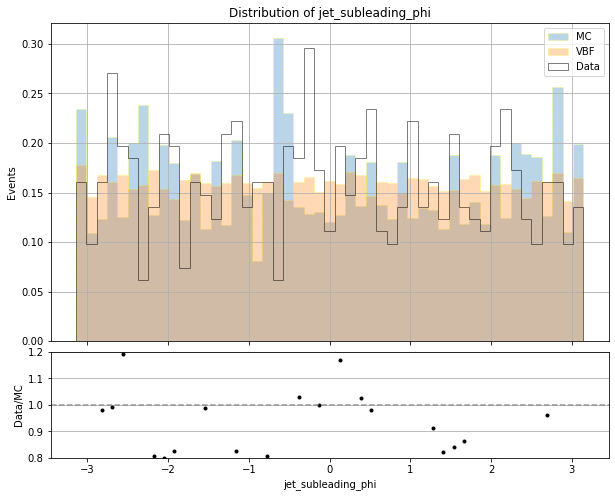

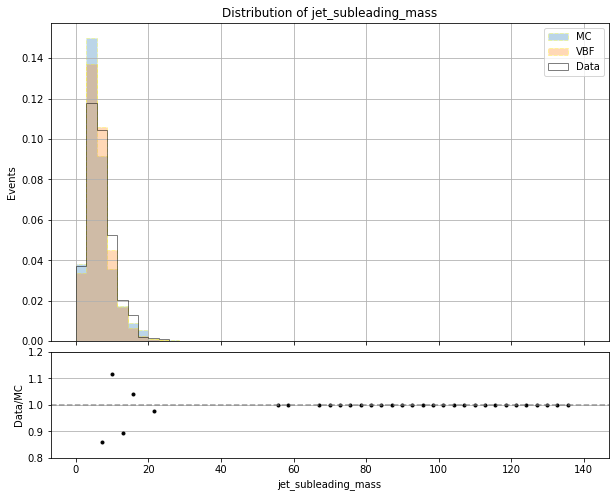

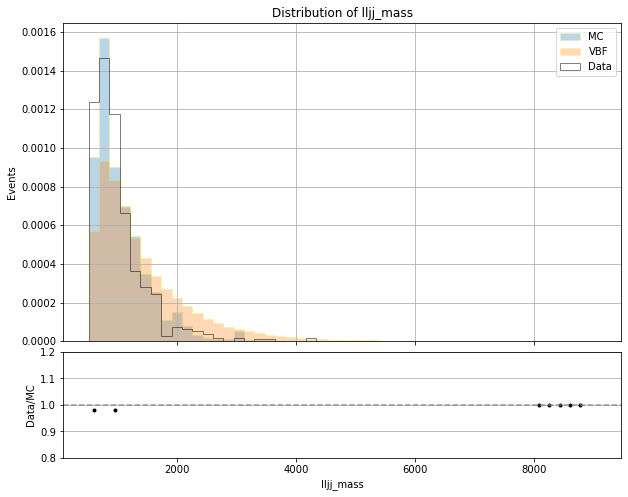

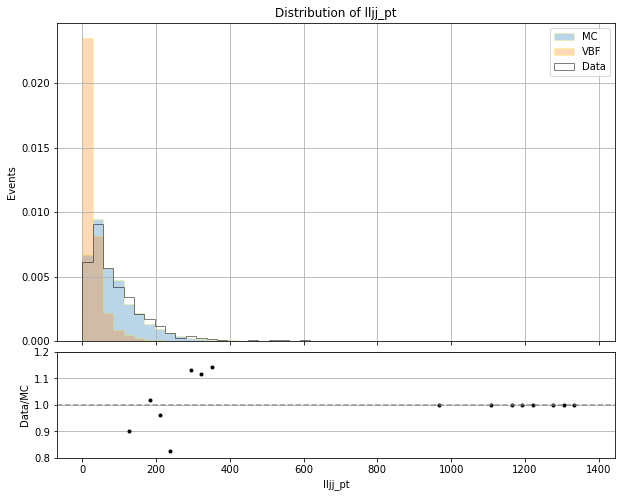

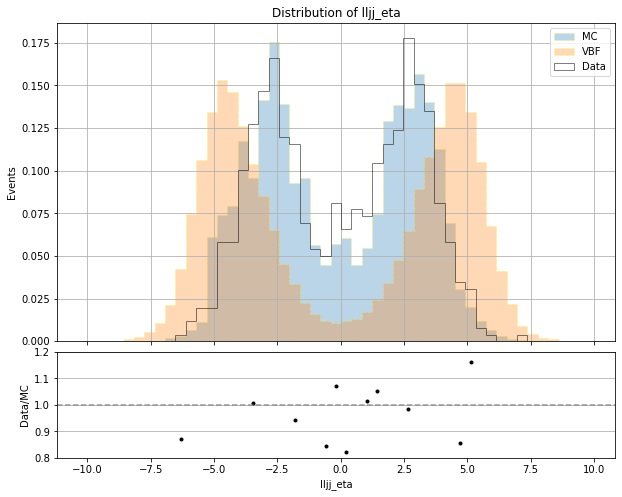

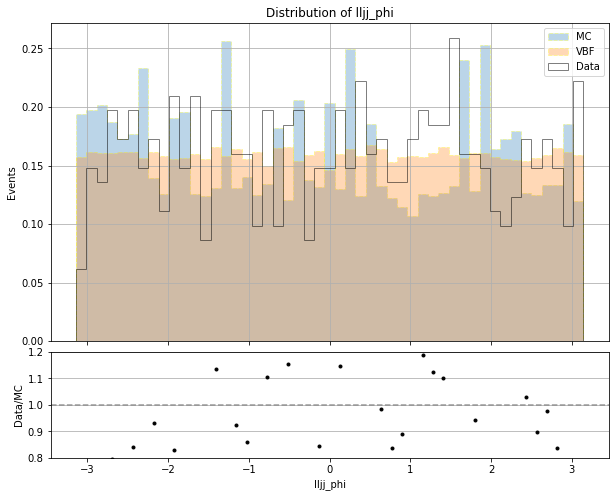

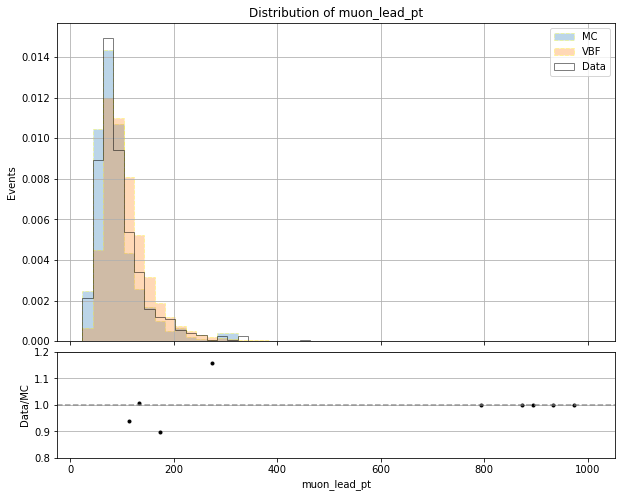

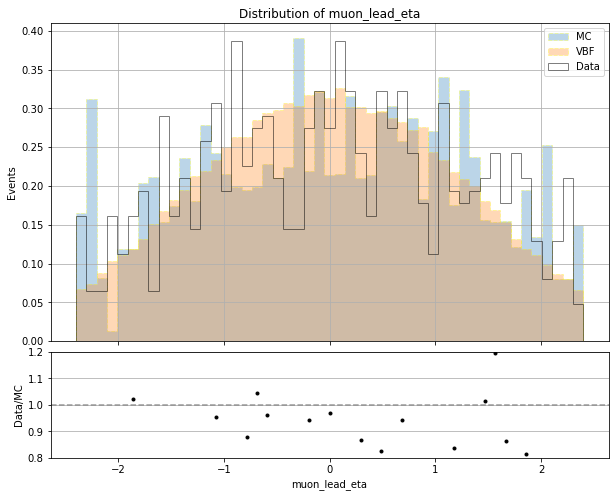

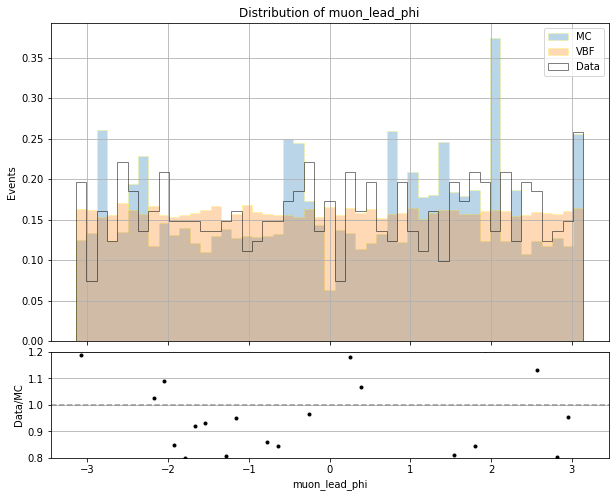

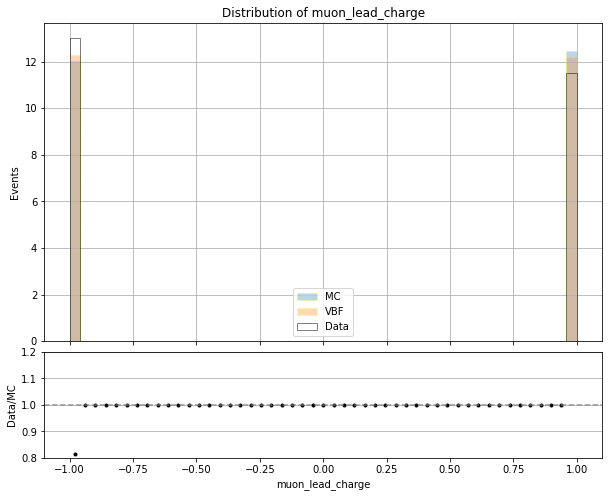

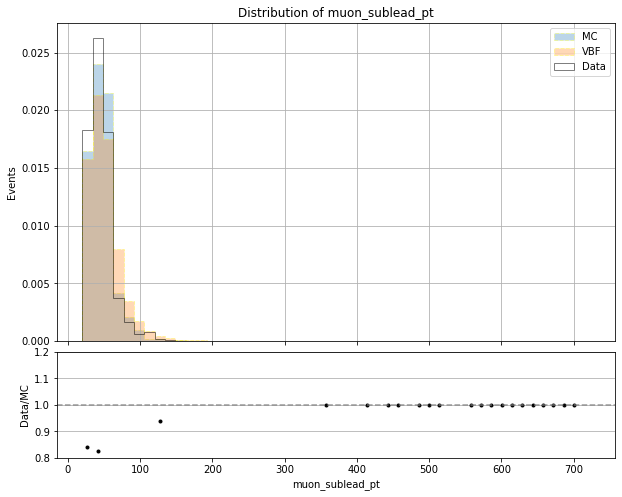

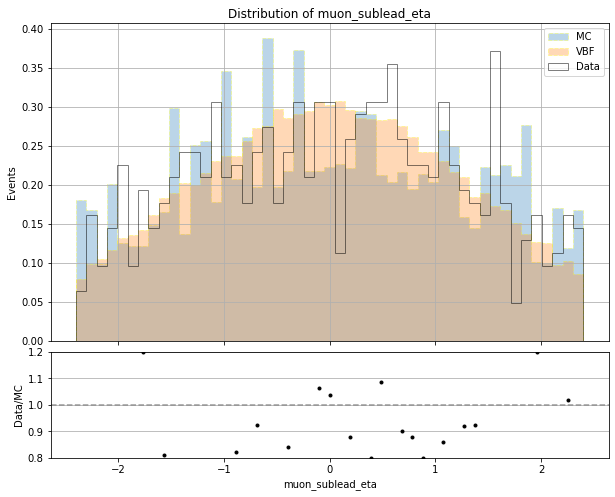

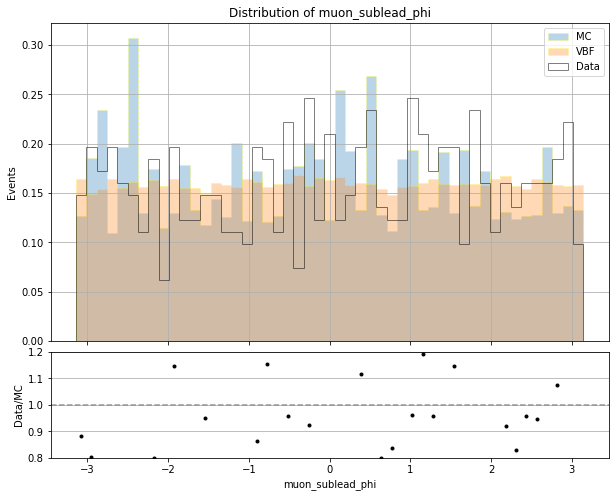

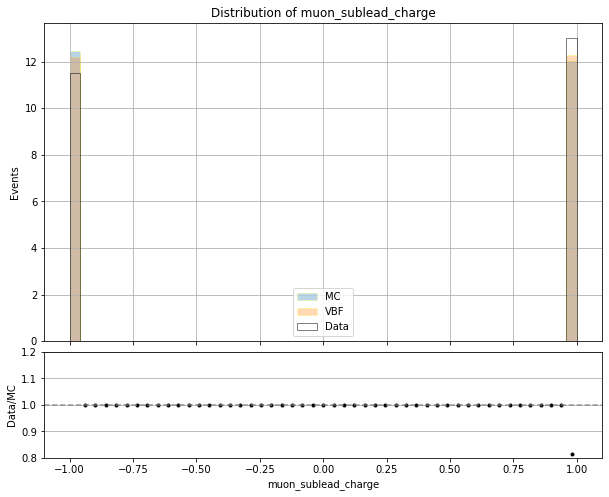

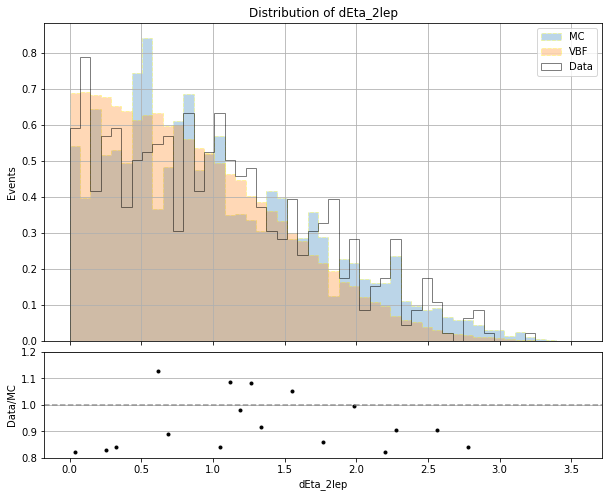

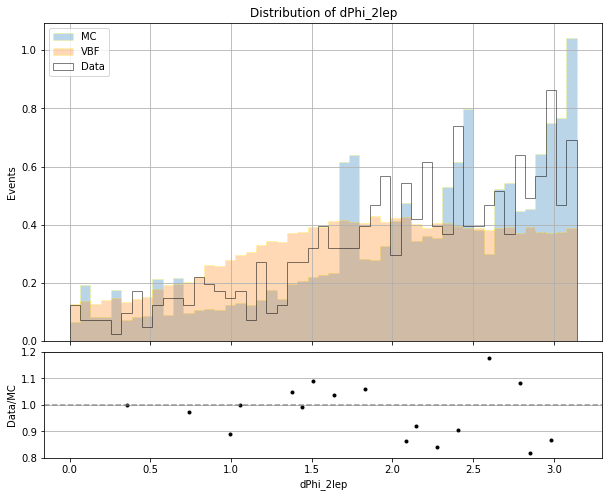

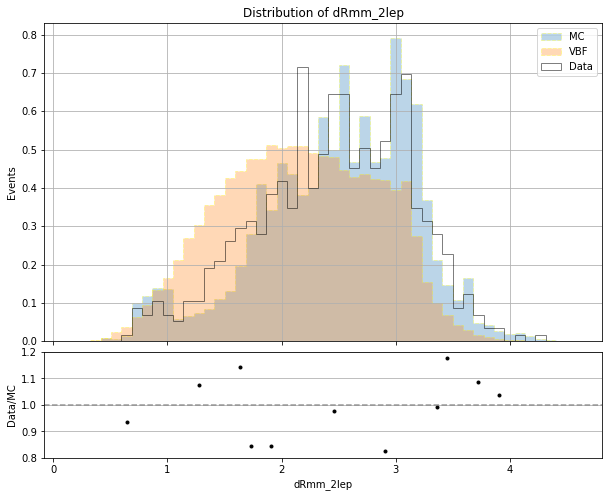

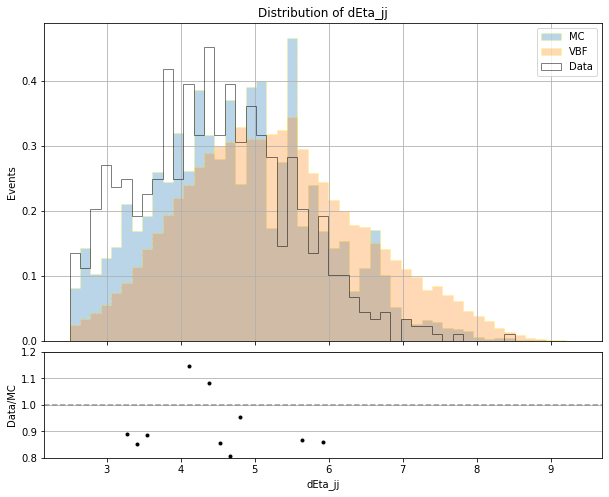

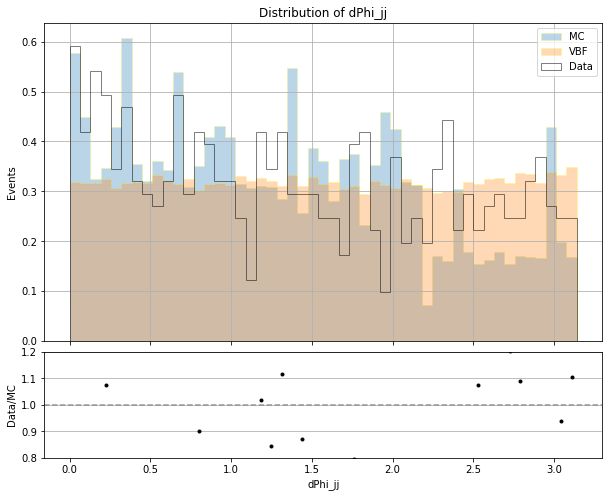

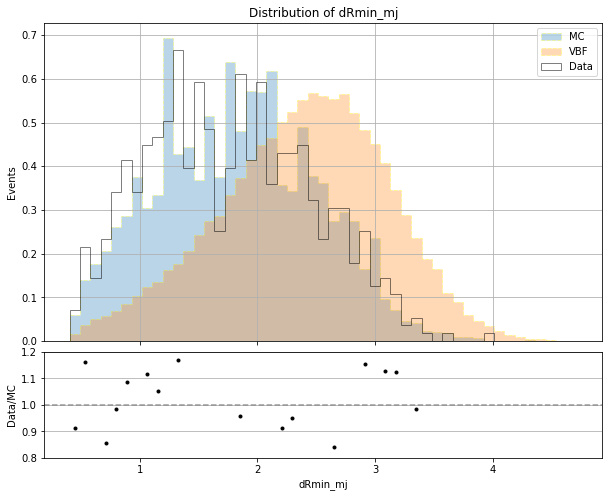

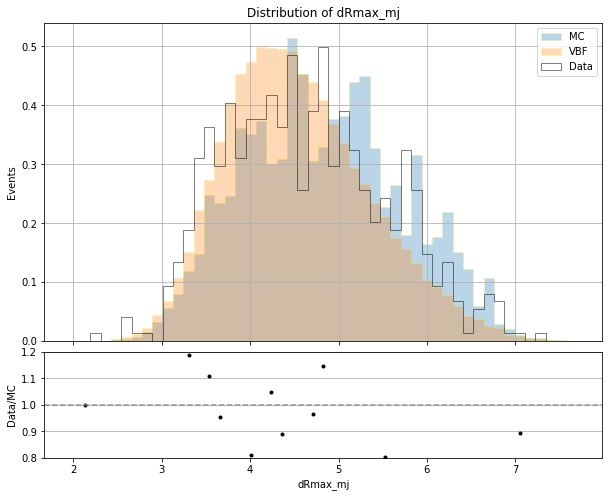

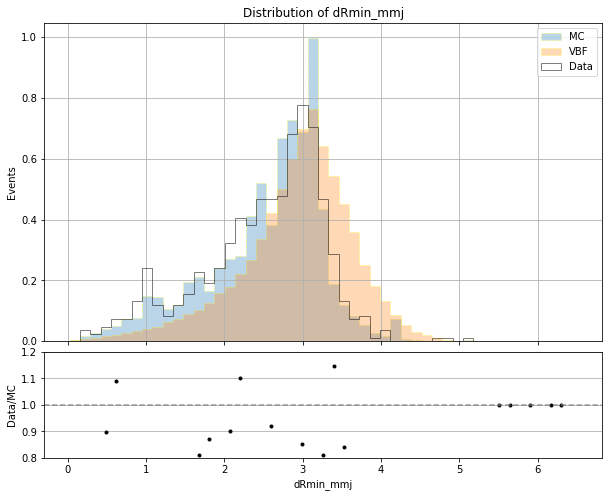

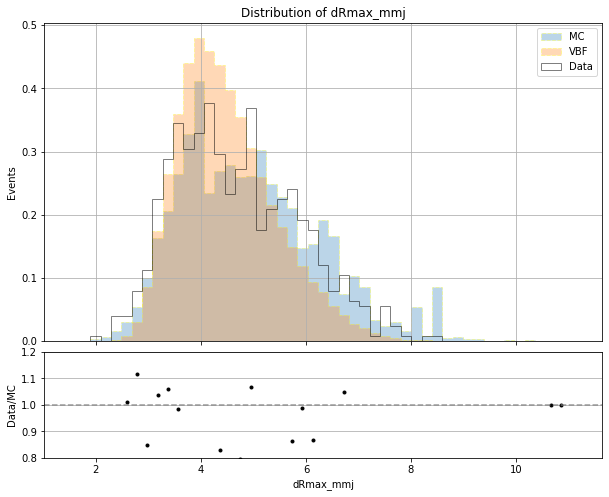

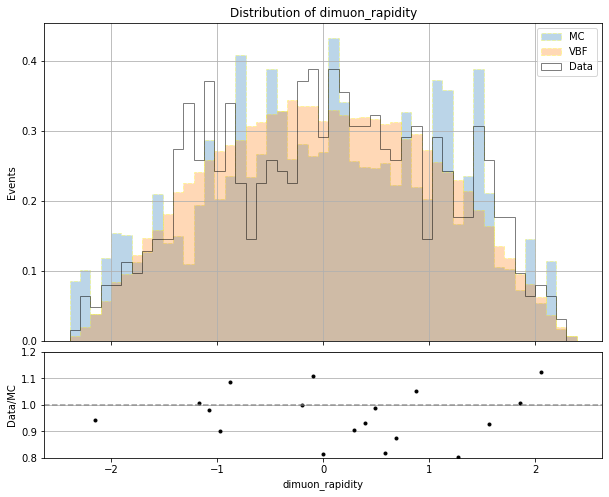

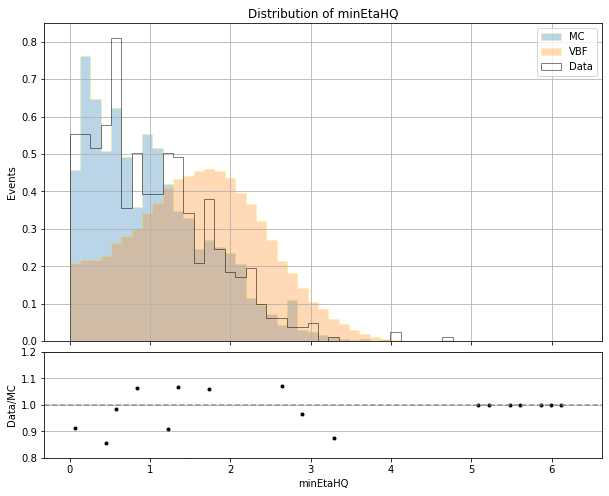

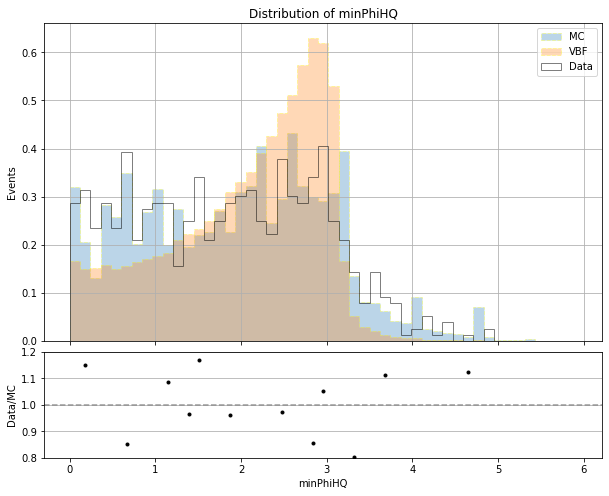

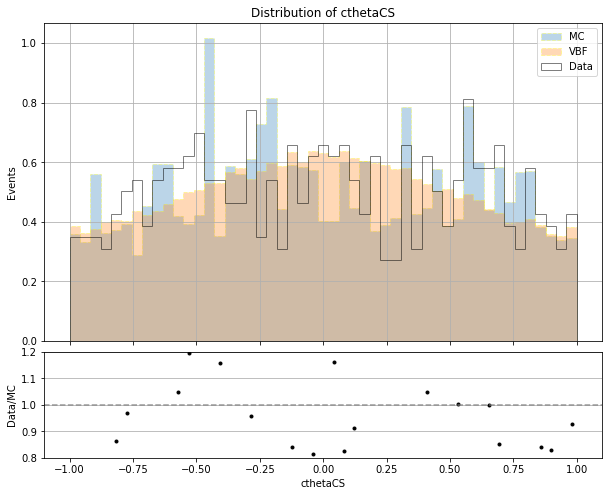

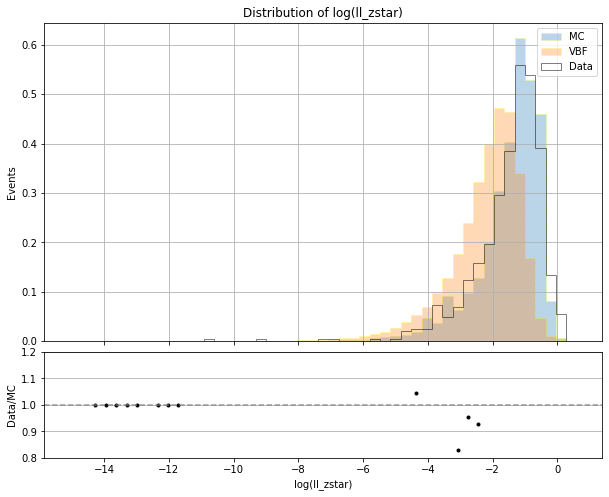

In [10]:
import matplotlib.pyplot as plt
import numpy as np

for var in VARS:#['jet_leading_eta','jet_subleading_eta','dimuon_mass']:

    fig, (ax_main, ax_ratio) = plt.subplots(
        2, 1, 
        figsize=(10, 8), 
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=True
    )
    

    if var in ['jet_leading_eta','jet_subleading_eta']:
        bins = np.linspace(-5,5,50)
    else:
        bins = np.linspace(df_2022[var].min(),df_2022[var].max(),50)
    

    scaled_weights = df_2022['WET']
    

    mc_mask = df_2022['category'] != 'data'
    data_mask = df_2022['category'] == 'data'
    
    mc_counts, _ = np.histogram(df_2022[mc_mask][var], bins=bins, weights=scaled_weights[mc_mask])
    data_counts, _ = np.histogram(df_2022[data_mask][var], bins=bins, weights=scaled_weights[data_mask])
    

    ax_main.hist(
        df_2022[mc_mask][var], 
        bins=bins, 
        alpha=0.3, 
        weights=scaled_weights[mc_mask], 
        histtype='stepfilled', 
        edgecolor='yellow', 
        linestyle='--',
        label='MC',
        density=True
    )
    
    ax_main.hist(
        df_2022[df_2022['category'] == 'VBF'][var], 
        bins=bins, 
        alpha=0.3, 
        weights=scaled_weights[df_2022['category'] == 'VBF'], 
        histtype='stepfilled', 
        edgecolor='yellow', 
        linestyle='--',
        label='VBF',
        density=True
    )
    
    ax_main.hist(
        df_2022[data_mask][var], 
        bins=bins, 
        alpha=0.5, 
        weights=scaled_weights[data_mask], 
        histtype='step',
        edgecolor='black', 
        linestyle='-',
        label='Data',
        density=True
    )
    

    ax_main.set_ylabel('Events')
    ax_main.set_title(f'Distribution of {var}')
    ax_main.legend()
    ax_main.grid(True)
    

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.divide(data_counts, mc_counts, out=np.ones_like(data_counts), where=mc_counts!=0)
    

    bin_centers = 0.5*(bins[1:] + bins[:-1])
    

    ax_ratio.plot(
        bin_centers,     
        ratio,          
        markersize=3,      
        marker='o',           
        color='black',      
        linestyle='None',    
        label='Data/MC'      
    )
    

    ax_ratio.axhline(1, color='gray', ls='--', alpha=0.8)
    ax_ratio.set_ylabel('Data/MC')
    ax_ratio.set_ylim(0.8, 1.2)
    ax_ratio.grid(True, axis='y')
    

    ax_ratio.set_xlabel(f'{var}')
    

    plt.subplots_adjust(hspace=0.05)
    plt.show()

In [11]:
print("VBF count",df_2022[(df_2022['category']=='VBF')]['WET'].sum())
print("DY count",df_2022[(df_2022['category']=='DY')]['WET'].sum())
print("EWK count",df_2022[(df_2022['category']=='EWK')]['WET'].sum())
print("tt count",df_2022[(df_2022['category']=='tt')]['WET'].sum())
print("data count",df_2022[(df_2022['category']=='data')]['WET'].sum())

VBF count 1.2761482286340284
DY count 474.4334342524409
EWK count 12.068059319028631
tt count 340.98243895841733
data count 633.0


In [12]:
df_2022['isSignal'] = np.where(df_2022['category'] == 'VBF', 1, 0)
df= df_2022[VARS + ['isSignal']]

'''
df= df_2022[VARS + ['isSignal']+['WET']+['category']]

df_2022['isSignal'] = np.where(df_2022['category'] == 'VBF', 1, 0)

df_2022['ave_WET'] = 1

for cat in ['VBF', 'DY', 'EWK']:
    mask = df_2022['category'] == cat
    ave_weight = df_2022.loc[mask, 'WET'].mean()
    df_2022.loc[mask, 'ave_WET'] = df_2022.loc[mask, 'WET'] / ave_weight

df= df_2022[VARS + ['isSignal']+['ave_WET']+['category']]
'''

"\ndf= df_2022[VARS + ['isSignal']+['WET']+['category']]\n\ndf_2022['isSignal'] = np.where(df_2022['category'] == 'VBF', 1, 0)\n\ndf_2022['ave_WET'] = 1\n\nfor cat in ['VBF', 'DY', 'EWK']:\n    # 筛选当前分类的布尔索引\n    mask = df_2022['category'] == cat\n    ave_weight = df_2022.loc[mask, 'WET'].mean()\n    df_2022.loc[mask, 'ave_WET'] = df_2022.loc[mask, 'WET'] / ave_weight\n\ndf= df_2022[VARS + ['isSignal']+['ave_WET']+['category']]\n"

In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
NDIM = len(VARS)

# simpler model for quick run and check
config = {
    'input_dim': NDIM,        
    'd_model': 64, #128,      
    'nhead': 4, #8,             
    'num_layers': 2, #4,          
    'dim_feedforward': 128, #256,   
    'dropout': 0.1,            
    'batch_size': 1024,        
    'learning_rate': 3e-4,     
    'num_epochs': 20,           
    'pos_encoding': 'learnable',
    'pooling': 'cls_token',     
    'weight_decay': 5e-4 #1e-5    
}


Using device: cpu


In [43]:
class PhysicsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


class PhysicsTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.feature_embedding = nn.Linear(1, config['d_model'])
        
        if config['pos_encoding'] == 'fixed':
            self.position_embedding = PositionalEncoding(config['d_model'], config['dropout'])
        elif config['pos_encoding'] == 'learnable':
            self.position_embedding = LearnablePositionalEncoding(config['d_model'], config['input_dim'])
        else:
            self.position_embedding = None
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, config['d_model']))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config['d_model'],
            nhead=config['nhead'],
            dim_feedforward=config['dim_feedforward'],
            dropout=config['dropout'],
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=config['num_layers']
        )
        
        self.pooling = config['pooling']
        
        self.classifier = nn.Sequential(
            nn.Linear(config['d_model'], 64),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        x = x.unsqueeze(-1)
        
        x = self.feature_embedding(x)
        
        if self.position_embedding:
            x = self.position_embedding(x)
        

        if self.pooling == 'cls_token':
            cls_tokens = self.cls_token.repeat(batch_size, 1, 1)
            x = torch.cat([cls_tokens, x], dim=1)  
        

        x = self.transformer_encoder(x)
        
        if self.pooling == 'cls_token':
            x = x[:, 0, :] 
        elif self.pooling == 'mean':
            x = x.mean(dim=1)
        else:  
            x = x.max(dim=1)[0]
            

        return self.classifier(x).squeeze()


In [44]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=50):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super().__init__()
        self.position_embedding = nn.Embedding(max_len, d_model)
        self.positions = torch.arange(max_len).unsqueeze(0)

    def forward(self, x):
        positions = self.positions[:, :x.size(1)].to(x.device)
        pos_emb = self.position_embedding(positions)
        return x + pos_emb


In [45]:
def plot_roc_curve(y_true, y_score, title='Receiver Operating Characteristic'):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return roc_auc


In [46]:
def train_transformer(df):
    X = df[VARS].values
    y = df['isSignal'].values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    train_dataset = PhysicsDataset(X_train, y_train)
    test_dataset = PhysicsDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, 
                             batch_size=config['batch_size'], 
                             shuffle=True,
                             pin_memory=True)
    test_loader = DataLoader(test_dataset, 
                            batch_size=config['batch_size']*2,
                            shuffle=False,
                            pin_memory=True)
    
    model = PhysicsTransformer(config).to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), 
                           lr=config['learning_rate'], 
                           weight_decay=config['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'max', patience=5, factor=0.5, verbose=True
    )
    
    best_auc = 0
    train_losses = []
    test_aucs = []
    
    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        train_preds, train_labels = [], []
        
        batch_desc = f'Epoch {epoch+1}/{config["num_epochs"]}'
        batch_progress = tqdm(train_loader, desc=batch_desc, leave=False)
        
        for features, labels in batch_progress:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            batch_progress.set_postfix({'loss': f'{loss.item():.4f}'})
        
        batch_progress.close()
        
        train_auc = roc_auc_score(train_labels, train_preds)
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        model.eval()
        test_preds, test_labels = [], []
        with torch.no_grad():
            val_progress = tqdm(test_loader, desc=f'Validating epoch {epoch+1}', leave=False)
            for features, labels in val_progress:
                features = features.to(device)
                outputs = model(features).cpu().numpy()
                test_preds.extend(outputs)
                test_labels.extend(labels.numpy())
            val_progress.close()
        
        test_auc = roc_auc_score(test_labels, test_preds)
        test_aucs.append(test_auc)
        scheduler.step(test_auc)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        tqdm.write(f'Epoch {epoch+1}/{config["num_epochs"]}: '
                   f'Loss={avg_loss:.4f}, '
                   f'Train AUC={train_auc:.4f}, '
                   f'Test AUC={test_auc:.4f}, '
                   f'LR={current_lr:.2e}')
        
        if test_auc > best_auc:
            best_auc = test_auc
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': config,
                'scaler': scaler,
                'best_auc': best_auc
            }, 'TRSF_model_115-135.pth')
            print(f"Saved new best model with test AUC: {best_auc:.4f}")
    
    test_preds = np.array(test_preds)
    test_y = np.array(test_labels)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(test_aucs, label='Test AUC', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.suptitle('Training Progress')
    plt.show()
    
    roc_auc = plot_roc_curve(test_y, test_preds, title='Transformer ROC Curve')
    
    print("Adding predictions to the DataFrame...")
    df['TRSF_prob'] = np.nan
    df['TRSF_pred'] = np.nan
    
    test_idx = df.index[df.index.isin(test_dataset.features.index)]
    df.loc[test_idx, 'TRSF_prob'] = test_preds
    df.loc[test_idx, 'TRSF_pred'] = (test_preds > 0.5).astype(int)
    
    model.eval()
    with torch.no_grad():
        train_preds = []
        for i in range(0, len(X_train), config['batch_size']*4):
            batch = torch.tensor(
                X_train[i:i+config['batch_size']*4], 
                dtype=torch.float32
            ).to(device)
            preds = model(batch).cpu().numpy()
            train_preds.append(preds)
        
        train_preds = np.concatenate(train_preds)
        train_idx = df.index[df.index.isin(train_dataset.features.index)]
        df.loc[train_idx, 'TRSF_prob'] = train_preds
        df.loc[train_idx, 'TRSF_pred'] = (train_preds > 0.5).astype(int)
    
    print(f"Training completed. Best Test AUC: {best_auc:.4f}")
    
    return df, model, scaler


Epoch 1/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/20: Loss=0.5743, Train AUC=0.7093, Test AUC=0.9104, LR=3.00e-04
Saved new best model with test AUC: 0.9104


Epoch 2/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/20: Loss=0.3401, Train AUC=0.9168, Test AUC=0.9389, LR=3.00e-04
Saved new best model with test AUC: 0.9389


Epoch 3/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/20: Loss=0.3077, Train AUC=0.9327, Test AUC=0.9452, LR=3.00e-04
Saved new best model with test AUC: 0.9452


Epoch 4/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/20: Loss=0.2968, Train AUC=0.9376, Test AUC=0.9469, LR=3.00e-04
Saved new best model with test AUC: 0.9469


Epoch 5/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/20: Loss=0.2933, Train AUC=0.9393, Test AUC=0.9478, LR=3.00e-04
Saved new best model with test AUC: 0.9478


Epoch 6/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 6:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/20: Loss=0.2895, Train AUC=0.9411, Test AUC=0.9487, LR=3.00e-04
Saved new best model with test AUC: 0.9487


Epoch 7/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 7:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/20: Loss=0.2873, Train AUC=0.9416, Test AUC=0.9492, LR=3.00e-04
Saved new best model with test AUC: 0.9492


Epoch 8/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 8:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/20: Loss=0.2842, Train AUC=0.9427, Test AUC=0.9495, LR=3.00e-04
Saved new best model with test AUC: 0.9495


Epoch 9/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 9:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/20: Loss=0.2822, Train AUC=0.9437, Test AUC=0.9504, LR=3.00e-04
Saved new best model with test AUC: 0.9504


Epoch 10/20:   0%|          | 0/90 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validating epoch 16:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/20: Loss=0.2761, Train AUC=0.9462, Test AUC=0.9515, LR=3.00e-04


Epoch 17/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 17:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/20: Loss=0.2742, Train AUC=0.9469, Test AUC=0.9522, LR=3.00e-04
Saved new best model with test AUC: 0.9522


Epoch 18/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 18:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18/20: Loss=0.2728, Train AUC=0.9474, Test AUC=0.9520, LR=3.00e-04


Epoch 19/20:   0%|          | 0/90 [00:00<?, ?it/s]

Validating epoch 19:   0%|          | 0/12 [00:00<?, ?it/s]

Validating epoch 20:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20/20: Loss=0.2722, Train AUC=0.9476, Test AUC=0.9526, LR=3.00e-04
Saved new best model with test AUC: 0.9526


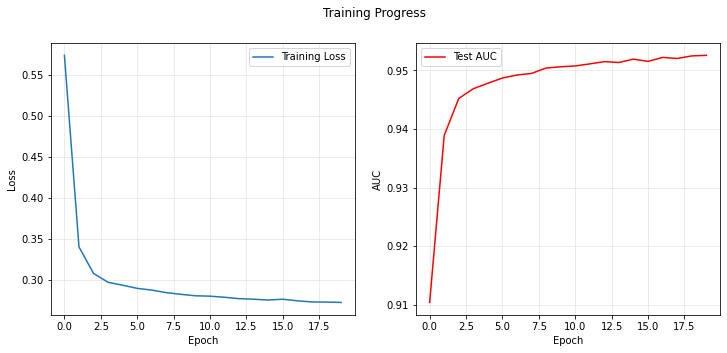

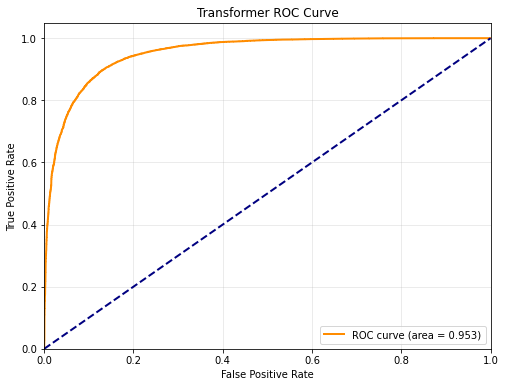

Adding predictions to the DataFrame...


AttributeError: 'Tensor' object has no attribute 'index'

In [47]:
# run the training
df_pre, model, scaler = train_transformer(df)

In [49]:
def load_transformer_model(model_path='TRSF_model_115-135.pth'):
    checkpoint = torch.load(model_path, map_location=device)
    config = checkpoint['config']
    scaler = checkpoint['scaler']
    
    model = PhysicsTransformer(config).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Loaded model with test AUC: {checkpoint['best_auc']:.4f}")
    return model, scaler

def predict_with_transformer(model, scaler, df):
    X = df[VARS].values
    
    X_scaled = scaler.transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    
    probabilities = []
    batch_size = config['batch_size'] * 4  
    
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            outputs = model(batch).cpu().numpy()
            probabilities.extend(outputs)
    
    probabilities = np.array(probabilities)
    
    df['TRSF_prob'] = probabilities
    df['TRSF_pred'] = (probabilities > 0.5).astype(int)
    
    return df

In [130]:
import torch
import numpy as np
import pandas as pd
import uproot
import os
import gc


lumi_2022=7980
lumi_2022EE=26670

root_dir = "/eos/user/y/yulou/HiggsDNA/samples/5-6_right/2022sample"
file_keyword = "NOTAG"
suffix_2022 = "2022"
suffix_2022EE = "2022EE"

paths_2022 = []
paths_2022EE = []

for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".parquet") and file_keyword in file:
            parent_folder = os.path.basename(root)
            if parent_folder.endswith(suffix_2022):
                paths_2022.append(os.path.join(root, file))
            elif parent_folder.endswith(suffix_2022EE):
                paths_2022EE.append(os.path.join(root, file))



df_2022EE = pd.concat(
    [pd.read_parquet(path, engine='pyarrow').assign(file_path=path) for path in paths_2022EE],
    ignore_index=True
)
df_2022EE['lumi'] = lumi_2022EE

df_2022MC=df_2022EE
del df_2022EE
gc.collect()



43410

In [131]:
conditions = [
    df_2022MC['file_path'].str.contains('VBF'), 
    df_2022MC['file_path'].str.contains('DY'),
    df_2022MC['file_path'].str.contains('EWK'),
    df_2022MC['file_path'].str.contains('TTto2L2Nu')
]
choices = ['VBF', 'DY','EWK','tt']
df_2022MC['category'] = np.select(conditions, choices, default='others')  

df_2022MC['WET']=df_2022MC['weight']*df_2022MC['lumi']*df_2022MC['cross_section']

In [132]:
df_2022data=pd.concat(
    [pd.read_parquet(path, engine='pyarrow').assign(file_path=path) for path in [
        "/eos/user/y/yulou/HiggsDNA/samples/5-6_right/2022sample/Data/DataE_2022_NOTAG_merged.parquet",
        "/eos/user/y/yulou/HiggsDNA/samples/5-6_right/2022sample/Data/DataF_2022_NOTAG_merged.parquet",     
        "/eos/user/y/yulou/HiggsDNA/samples/5-6_right/2022sample/Data/DataG_2022_NOTAG_merged.parquet", 
    ]],
    ignore_index=True
)

df_2022data['category']='data'
df_2022data['WET']=1

In [133]:
df_all=pd.concat([df_2022MC, df_2022data], axis=0)
del df_2022MC, df_2022data
gc.collect()

18

In [134]:

df_all=df_all[(df_all['dimuon_mass'] > 115) & (df_all['dimuon_mass'] < 135)]

df_all=df_all[abs(df_all['jet_leading_eta'] - df_all['jet_subleading_eta'])>2.5]
df_all=df_all[(df_all['dijet_mass']> 400)]

no_horn_region = ~((abs(df_all['jet_leading_eta']) > 2.6) & (abs(df_all['jet_leading_eta']) < 2.9)) | ((abs(df_all['jet_subleading_eta']) > 2.6) & (abs(df_all['jet_subleading_eta']) < 2.9))

if arg_no_horn==1:
    df_all= df_all[no_horn_region]



In [135]:
VARS = [           
            'dimuon_mass', 'dimuon_pt', 'dimuon_eta', 'dimuon_phi',
                  
            'dijet_pt', 'dijet_eta', 'dijet_phi', 'dijet_mass', 
    
            'jet_leading_pt', 'jet_leading_eta', 'jet_leading_phi','jet_leading_mass',
            'jet_subleading_pt', 'jet_subleading_eta', 'jet_subleading_phi','jet_subleading_mass',
            #'jet_lead_btagDeepFlav_QG','jet_sublead_btagDeepFlav_QG',
        
            "lljj_mass",   
            "lljj_pt"  ,   
            "lljj_eta" ,
            "lljj_phi" ,
            
            'muon_lead_pt', 'muon_lead_eta', 'muon_lead_phi', 'muon_lead_charge', 
            'muon_sublead_pt', 'muon_sublead_eta', 'muon_sublead_phi', 'muon_sublead_charge',
            #'muon_sublead_mass',   'muon_lead_mass',
            
            'dEta_2lep',
            'dPhi_2lep',
            'dRmm_2lep',
            
            "dEta_jj"  ,# already abs value
            #"dEta_jj_abs",
            "dPhi_jj"  ,
            #??"dPhi_jj_mod"    : (op.deltaPhi(jets[0].p4, jets[1].p4) + np.pi) % (2 * np.pi) - np.pi,
            #??"dPhi_jj_mod_abs": op.abs((op.deltaPhi(jets[0].p4, jets[1].p4) + np.pi) % (2 * np.pi) - np.pi),
            
            "dRmin_mj","dRmax_mj",'dRmin_mmj','dRmax_mmj',
        
            'dimuon_rapidity',#Higgs rapidity
            'minEtaHQ','minPhiHQ',#mm_eta-jet_eta'
            #'Rpt',the value is 1
            'cthetaCS',#!!! need to be checked
            'log(ll_zstar)'
        
        #other vars in run2
        
        
        
       ]

df_all['dEta_2lep'] = abs(df_all['muon_lead_eta']-df_all['muon_sublead_eta'])
df_all['dPhi_2lep'] = abs(df_all['muon_lead_phi']-df_all['muon_sublead_phi'])
df_all['dPhi_2lep'] = np.where(df_all['dPhi_2lep'] > np.pi, 2*np.pi - df_all['dPhi_2lep'], df_all['dPhi_2lep'])
df_all['dRmm_2lep'] = np.sqrt(df_all['dEta_2lep']**2 + df_all['dPhi_2lep']**2)

df_all['dEta_jj'] = abs(df_all['jet_leading_eta']-df_all['jet_subleading_eta'])
df_all['dPhi_jj'] = abs(df_all['jet_leading_phi']-df_all['jet_subleading_phi'])
df_all['dPhi_jj'] = np.where(df_all['dPhi_jj'] > np.pi, 2*np.pi - df_all['dPhi_jj'], df_all['dPhi_jj'])

dimuon_px = df_all['dimuon_pt'] * np.cos(df_all['dimuon_phi'])
dimuon_py = df_all['dimuon_pt'] * np.sin(df_all['dimuon_phi'])
dimuon_pz = df_all['dimuon_pt'] * np.sinh(df_all['dimuon_eta'])
dimuon_E = np.sqrt(dimuon_px**2 + dimuon_py**2 + dimuon_pz**2 + df_all['dimuon_mass']**2)

dijet_px = df_all['dijet_pt'] * np.cos(df_all['dijet_phi'])
dijet_py = df_all['dijet_pt'] * np.sin(df_all['dijet_phi'])
dijet_pz = df_all['dijet_pt'] * np.sinh(df_all['dijet_eta'])
dijet_E = np.sqrt(dijet_px**2 + dijet_py**2 + dijet_pz**2 + df_all['dijet_mass']**2)

total_px = dimuon_px + dijet_px
total_py = dimuon_py + dijet_py
total_pz = dimuon_pz + dijet_pz
total_E = dimuon_E + dijet_E

df_all['lljj_pt'] = np.sqrt(total_px**2 + total_py**2)
df_all['lljj_phi'] = np.arctan2(total_py, total_px)
df_all['lljj_eta'] = np.arcsinh(total_pz / df_all['lljj_pt'])
df_all['lljj_mass'] = np.sqrt(total_E**2 - (total_px**2 + total_py**2 + total_pz**2))

df_all['dimuon_rapidity'] = 0.5 * np.log(
    (dimuon_E + dimuon_pz) / 
    (dimuon_E - dimuon_pz)
)

def calculate_rapidity(var):

    pt = df_all[f'{var}_pt']
    eta = df_all[f'{var}_eta']
    phi = df_all[f'{var}_phi']
    mass = df_all[f'{var}_mass']

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
        
    rapidity = 0.5 * np.log( (E + pz) / (E - pz))
    return rapidity

df_all['jet_leading_rapidity'] = calculate_rapidity("jet_leading")
df_all['jet_subleading_rapidity'] = calculate_rapidity("jet_subleading")

df_all['log(ll_zstar)'] = np.log(abs((df_all['dimuon_rapidity'] - 0.5*(df_all['jet_leading_rapidity'] + df_all['jet_subleading_rapidity']))/(df_all['jet_leading_rapidity']-df_all['jet_subleading_rapidity'])))


def deltaR(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = np.abs(phi1 - phi2) % (2 * np.pi)  
    dphi = np.where(dphi > np.pi, 2 * np.pi - dphi, dphi)  
    return np.sqrt(deta**2 + dphi**2)


df_all['dR_mu1_j1'] = deltaR(df_all['muon_lead_eta'], df_all['muon_lead_phi'], 
                             df_all['jet_leading_eta'], df_all['jet_leading_phi'])
df_all['dR_mu1_j2'] = deltaR(df_all['muon_lead_eta'], df_all['muon_lead_phi'], 
                             df_all['jet_subleading_eta'], df_all['jet_subleading_phi'])
df_all['dR_mu2_j1'] = deltaR(df_all['muon_sublead_eta'], df_all['muon_sublead_phi'], 
                             df_all['jet_leading_eta'], df_all['jet_leading_phi'])
df_all['dR_mu2_j2'] = deltaR(df_all['muon_sublead_eta'], df_all['muon_sublead_phi'], 
                             df_all['jet_subleading_eta'], df_all['jet_subleading_phi'])


df_all['dRmin_mj'] = df_all[['dR_mu1_j1', 'dR_mu1_j2', 'dR_mu2_j1', 'dR_mu2_j2']].min(axis=1)
df_all['dRmax_mj'] = df_all[['dR_mu1_j1', 'dR_mu1_j2', 'dR_mu2_j1', 'dR_mu2_j2']].max(axis=1)


df_all = df_all.drop(columns=['dR_mu1_j1', 'dR_mu1_j2', 'dR_mu2_j1', 'dR_mu2_j2'])

dR_pairs_mmj = [
    deltaR(df_all['dimuon_eta'], df_all['dimuon_phi'], 
           df_all['jet_leading_eta'], df_all['jet_leading_phi']),
    deltaR(df_all['dimuon_eta'], df_all['dimuon_phi'], 
           df_all['jet_subleading_eta'], df_all['jet_subleading_phi'])
]
df_all['dRmin_mmj'] = np.min(dR_pairs_mmj, axis=0)
df_all['dRmax_mmj'] = np.max(dR_pairs_mmj, axis=0)


df_all['minEtaHQ_j1'] = abs(df_all['dimuon_eta'] - df_all['jet_leading_eta'])
df_all['minEtaHQ_j2'] = abs(df_all['dimuon_eta'] - df_all['jet_subleading_eta'])
df_all['minEtaHQ'] = df_all[['minEtaHQ_j1', 'minEtaHQ_j2']].min(axis=1)

df_all['minPhiHQ_j1'] = abs(df_all['dimuon_phi'] - df_all['jet_leading_phi'])
df_all['minPhiHQ_j2'] = abs(df_all['dimuon_phi'] - df_all['jet_subleading_phi'])
df_all['minPhiHQ'] = df_all[['minPhiHQ_j1', 'minPhiHQ_j2']].min(axis=1)


df_all['Rpt'] = df_all['lljj_pt'] / (df_all['dimuon_pt'] + df_all['jet_leading_pt'] + df_all['jet_subleading_pt'])


df_all['muon_lead_pz'] = df_all['muon_lead_pt'] * np.sinh(df_all['muon_lead_eta'])
df_all['muon_lead_E'] = np.sqrt(
    (df_all['muon_lead_pt'] * np.cosh(df_all['muon_lead_eta']))**2 + df_all['muon_lead_mass']**2
)

df_all['muon_sublead_pz'] = df_all['muon_sublead_pt'] * np.sinh(df_all['muon_sublead_eta'])
df_all['muon_sublead_E'] = np.sqrt(
    (df_all['muon_sublead_pt'] * np.cosh(df_all['muon_sublead_eta']))**2 + df_all['muon_sublead_mass']**2
)


numerator = 2 * (df_all['muon_lead_pz'] * df_all['muon_sublead_E'] - 
                df_all['muon_lead_E'] * df_all['muon_sublead_pz'])
denominator = df_all['dimuon_mass'] * np.sqrt(df_all['dimuon_mass']**2 + df_all['dimuon_pt']**2)
epsilon = 1e-8
df_all['cthetaCS'] = numerator / (denominator + epsilon)




In [136]:
#df_train=df_all[VARS]

In [137]:
loaded_model, loaded_scaler = load_transformer_model('TRSF_model_115-135_v1.pth')

df_all = predict_with_transformer(loaded_model, loaded_scaler, df_all)


Loaded model with test AUC: 0.9542


In [138]:
df_all['predictions']=df_all['TRSF_pred']

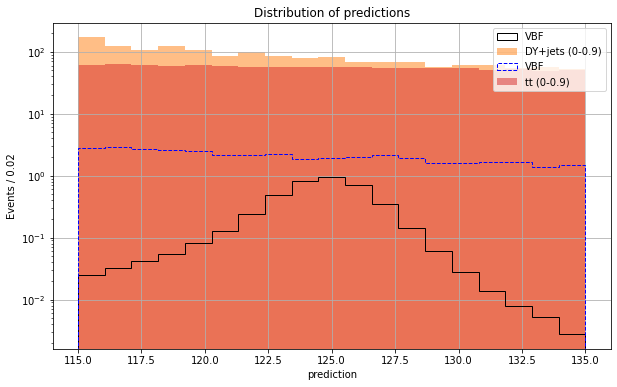

In [139]:
import matplotlib.pyplot as plt

df1=df_all

plt.figure(figsize=(10, 6))
bins_09 = np.linspace(115,135,20)  
scaled_weights = df1['WET']

plt.hist(df1[df1['category'].str.contains("VBF")]['dimuon_mass'], 
         bins=bins_09, #alpha=0.7, 
         weights=scaled_weights[df1['category'].str.contains("VBF")], 
         histtype='step', label='VBF', edgecolor='black', linestyle='-')
plt.hist(df1[df1['category'].str.contains("DY")]['dimuon_mass'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['category'].str.contains("DY")], 
         label='DY+jets (0-0.9)')
plt.hist(df1[df1['category'].str.contains("EWK")]['dimuon_mass'], 
         bins=bins_09, #alpha=0.5, 
         weights=scaled_weights[df1['category'].str.contains("EWK")], 
         histtype='step', label='VBF', edgecolor='blue', linestyle='--')
plt.hist(df1[df1['category'].str.contains("tt")]['dimuon_mass'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['category'].str.contains("tt")], 
         label='tt (0-0.9)')

plt.xlabel('prediction')
plt.ylabel('Events / 0.02')
plt.title(f'Distribution of predictions')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

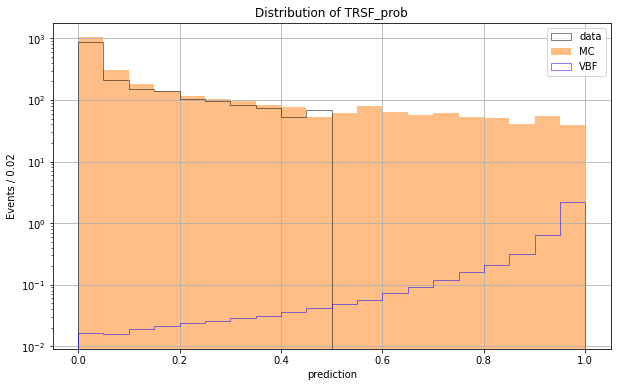

In [141]:
plt.figure(figsize=(10, 6))
bins_09 = np.linspace(0, 1, 21)  
scaled_weights = df1['WET']



plt.hist(df1[df1['category'].str.contains("data")]['TRSF_prob'], 
         bins= np.linspace(0, 0.5, 11)  , alpha=0.5, 
         weights=scaled_weights[df1['category'].str.contains("data")], 
         label='data',histtype='step', edgecolor='black', linestyle='-')
plt.hist(df1[~(df1['category'].str.contains("data"))]['TRSF_prob'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[~(df1['category'].str.contains("data"))], 
         label='MC')
plt.hist(df1[df1['category'].str.contains("VBF")]['TRSF_prob'], 
         bins= bins_09  , alpha=0.5, 
         weights=scaled_weights[df1['category'].str.contains("VBF")], 
         label='VBF',histtype='step', edgecolor='blue', linestyle='-')

plt.xlabel('prediction')
plt.ylabel('Events / 0.02')
plt.title(f'Distribution of TRSF_prob')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [142]:
print(df_all['TRSF_prob'])

3          0.379876
36         0.098254
41         0.331264
52         0.626625
60         0.769248
             ...   
1364628    0.440905
1365657    0.001225
1365686    0.008073
1366444    0.451474
1367892    0.018397
Name: TRSF_prob, Length: 389087, dtype: float32


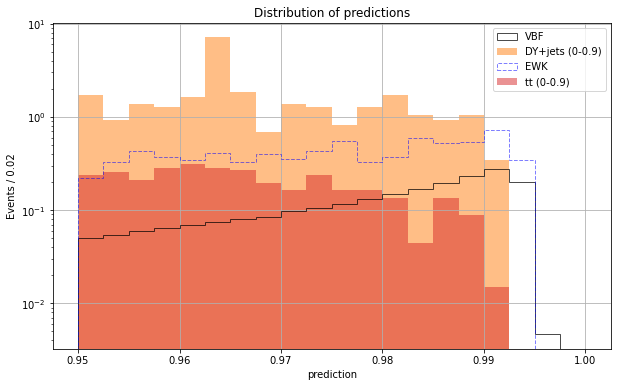

In [143]:
plt.figure(figsize=(10, 6))
bins_09 = np.linspace(0.95, 1, 21)  
scaled_weights = df1['WET']

plt.hist(df1[df1['category'].str.contains("VBF")]['TRSF_prob'], 
         bins=bins_09, alpha=0.7, 
         weights=scaled_weights[df1['category'].str.contains("VBF")], 
         histtype='step', label='VBF', edgecolor='black', linestyle='-')
plt.hist(df1[df1['category'].str.contains("DY")]['TRSF_prob'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['category'].str.contains("DY")], 
         label='DY+jets (0-0.9)')
plt.hist(df1[df1['category'].str.contains("EWK")]['TRSF_prob'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['category'].str.contains("EWK")], 
         histtype='step', label='EWK', edgecolor='blue', linestyle='--')
plt.hist(df1[df1['category'].str.contains("tt")]['TRSF_prob'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['category'].str.contains("tt")], 
         label='tt (0-0.9)')

plt.xlabel('prediction')
plt.ylabel('Events / 0.02')
plt.title(f'Distribution of predictions')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [145]:
print("VBF count",df1[(df1['category']=='VBF')]['WET'].sum())
print("DY count",df1[(df1['category']=='DY')]['WET'].sum())
print("EWK count",df1[(df1['category']=='EWK')]['WET'].sum())
print("tt count",df1[(df1['category']=='tt')]['WET'].sum())
print("others count",df1[(df1['category']=='others')]['WET'].sum())

VBF count 4.19054198562388
DY count 1613.261281544971
EWK count 39.2701189556364
tt count 1070.8839174019583
others count 26.4513802811613


In [146]:
bins_091 = np.linspace(0.98, 1, 21)


hist_VBF, _ = np.histogram(df1[df1['category'].str.contains("VBF")]['predictions'], 
                    bins=bins_091, 
                    weights=scaled_weights[df1['category'].str.contains("VBF")])

hist_DY, bin_edges = np.histogram(df1[df1['category'].str.contains("DY")]['predictions'], 
                                  bins=bins_091, 
                                  weights=scaled_weights[df1['category'].str.contains("DY")])
hist_tt, _ = np.histogram(df1[df1['category'].str.contains("tt")]['predictions'], 
                          bins=bins_091, 
                          weights=scaled_weights[df1['category'].str.contains("tt")])
hist_EWK, _ = np.histogram(df1[df1['category'].str.contains("EWK")]['predictions'], 
                           bins=bins_091, 
                           weights=scaled_weights[df1['category'].str.contains("EWK")])

# 计算每个bin内DY, EWK, tt的总和
sum_DY_EWK_tt = hist_DY + hist_EWK + hist_tt

sig=0 #significance
all_s=0
all_b=0

for b, s in zip(sum_DY_EWK_tt, hist_VBF,):
    #print(f'S:{s},B:{b}')
    #print((s+b)*np.log(1+s/b)-s)
    b+=1e-6
    all_s+=s
    all_b+=b
    sig+=2*((s+b)*np.log(1+s/b)-s)
print(f'Significance:{sig}')
print(f'Signal:{all_s},bkg:{all_b}')

Significance:0.027918510712840572
Signal:3.930412351186643,bkg:552.0211644497505


In [147]:
bins_091 = np.linspace(0.95, 1, 51)


hist_VBF, _ = np.histogram(df1[df1['category'].str.contains("VBF")]['TRSF_prob'], 
                    bins=bins_091, 
                    weights=scaled_weights[df1['category'].str.contains("VBF")])

hist_DY, bin_edges = np.histogram(df1[df1['category'].str.contains("DY")]['TRSF_prob'], 
                                  bins=bins_091, 
                                  weights=scaled_weights[df1['category'].str.contains("DY")])
hist_tt, _ = np.histogram(df1[df1['category'].str.contains("tt")]['TRSF_prob'], 
                          bins=bins_091, 
                          weights=scaled_weights[df1['category'].str.contains("tt")])
hist_EWK, _ = np.histogram(df1[df1['category'].str.contains("EWK")]['TRSF_prob'], 
                           bins=bins_091, 
                           weights=scaled_weights[df1['category'].str.contains("EWK")])

# 计算每个bin内DY, EWK, tt的总和
sum_DY_EWK_tt = hist_DY + hist_EWK + hist_tt

sig=0 #significance
all_s=0
all_b=0

for b, s in zip(sum_DY_EWK_tt, hist_VBF,):
    #print(f'S:{s},B:{b}')
    #print((s+b)*np.log(1+s/b)-s)
    b+=1e-6
    all_s+=s
    all_b+=b
    sig+=2*((s+b)*np.log(1+s/b)-s)
print(f'Significance:{sig}')
print(f'Signal:{all_s},bkg:{all_b}')

Significance:0.38934449368511226
Signal:2.215187785752244,bkg:37.178370082336265


In [148]:
print("Finished!")


Finished!
